In [ ]:
'''from Bio import SeqIO

with open('/Users/kalyanidhusia/Downloads/chr1.fa') as in_f, open('hg19chr1.bed','w') as out_f:
    for record in SeqIO.parse(in_f, 'fasta'):
        out_f.write('{}\t0\t{}\n'.format(record.id, len(record)))'''

In [1]:
import time
import gzip
import shutil
import pandas as pd
import numpy as np
import re
import twobitreader as tbr
from Bio import SeqIO
from numpy import array
from numpy import argmax
import matplotlib.pyplot as plt
from itertools import islice
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_mldata
from matplotlib import cm

import pylab as plt
import seaborn as sns; sns.set()

# change the path for fast-TSNE!
import sys; sys.path.append('/Users/kalyanidhusia/Downloads/FIt-SNE-master/')
from fast_tsne import fast_tsne

In [3]:
with open('positivechunk.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    sequences = []
    #label = 1
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequences.append((seq_record.seq).upper())
        #lengths.append(len(seq_record.seq))
    s1 = pd.Series(identifiers, name='ID')
    s2 = pd.Series(sequences, name='Seq')
    #s3 = pd.Series(lengths, name='len')
    pdf = pd.DataFrame(dict(ID=s1, sequences=s2, label=1)).set_index(['ID'])
pdf.head()
pdf.size

153440

In [4]:
with open('negativechunk.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    sequences = []
    lengths =[]
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequences.append((seq_record.seq).upper())
        lengths.append(len(seq_record.seq))
    s1 = pd.Series(identifiers, name='ID')
    s2 = pd.Series(sequences, name='Seq')
    s3 = pd.Series(lengths, name='len')
    ndf = pd.DataFrame(dict(ID=s1, sequences=s2, label=0)).set_index(['ID'])
ndf.head()
ndf.size

153440

In [5]:
df = pd.concat([pdf, ndf])
df.head()

,sequences,label
ID,,
chr1:843400-843500,"(A, G, A, C, A, C, C, C, A, G, A, C, T, G, A, ...",1
chr1:843500-843600,"(C, C, C, A, C, A, C, C, T, G, T, T, A, G, A, ...",1
chr1:843600-843700,"(C, A, G, G, C, C, A, G, G, C, C, C, A, C, A, ...",1
chr1:843700-843800,"(G, G, G, G, A, A, G, G, T, C, A, C, A, G, A, ...",1
chr1:846400-846500,"(C, T, G, G, G, C, A, G, G, A, T, T, T, G, G, ...",1


In [6]:
#One Hot Encoding Sequence
def oheSeq(DNAString):
    seq = DNAString.upper()
    nuc = 'ATGC'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in seq]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.append(letter)
    seq_ohe = np.asarray(OHE)
    return seq_ohe
print('done!')

done!


In [7]:
#Dimensionality Reductions
#euc for euclidean
#Dimensionality reduction using PCA takes ~30m mins
euc_ohe =  np.array([np.ravel(oheSeq(i)) for i in df['sequences']])
 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(euc_ohe)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
pca_result.size

Explained variation per principal component: [0.015992  0.0113169]


306880

In [8]:
dim1p = pca_result[:73369,0]
dim2p = pca_result[:73369,1]
dim1n = pca_result[73369:,0]
dim2n = pca_result[73369:,1]

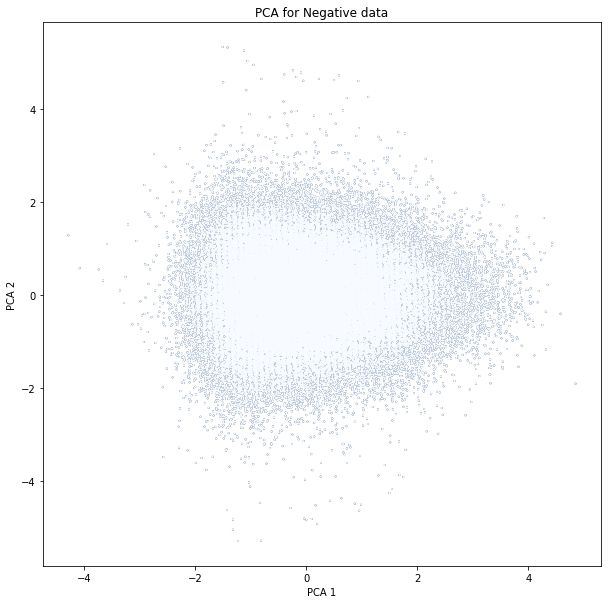

In [54]:
dim1 = pca_result[:,0]
dim2 = pca_result[:,1]
plt.figure(figsize=(10,10))
#plt.scatter(dim1, dim2,c='cyan', s=1)
plt.scatter(pca_result[:,0], pca_result[:,1], cmap='Blues',c=df['label'], s=1)
plt.title("PCA for Negative data")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

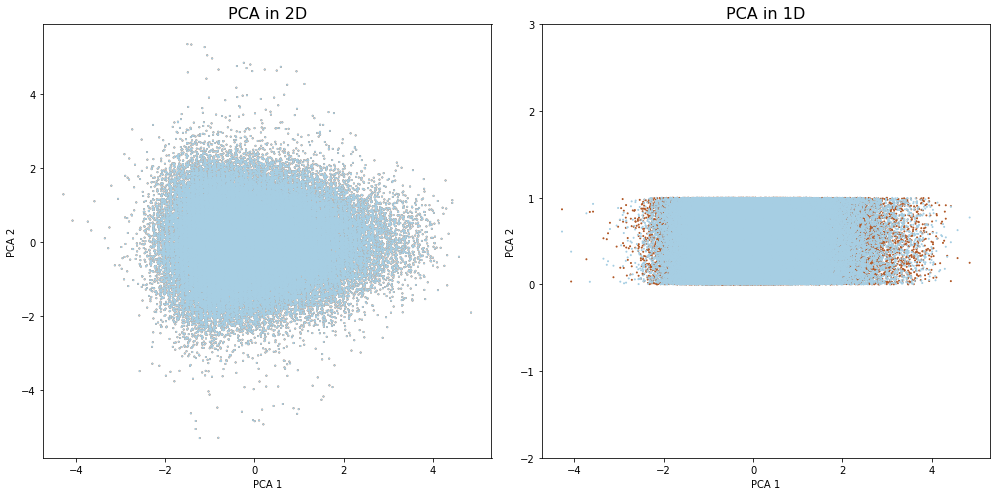

In [68]:
# Subsampling 
#Showcase of various other options
#orage are the positives and blues are negatives

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.scatter(pca_result[:,0], pca_result[:,1],cmap = 'Paired', c=df['label'], s=1) 
plt.title('PCA in 2D', fontsize=16)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.subplot(122)
plt.scatter(pca_result[:,0], np.random.uniform(size=dim2.shape[0]),cmap = 'Paired', c=df['label'], s=1)
plt.ylim([-2,3])
plt.title('PCA in 1D', fontsize=16)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.savefig('PCA_for_NRF2_2D_1D')

In [9]:
#Dimensionality Reductions
#euc for euclidean
#euc_ohe =  np.array([oheSeqMod(i, 6) for i in search_reg['binding']])
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
#import umap  
#Be careful with umap installation pip install umap will cause you to install the wrong ver of umap 
#(and will also break the real module)
X_embedded = TSNE(n_components=2).fit_transform(euc_ohe)

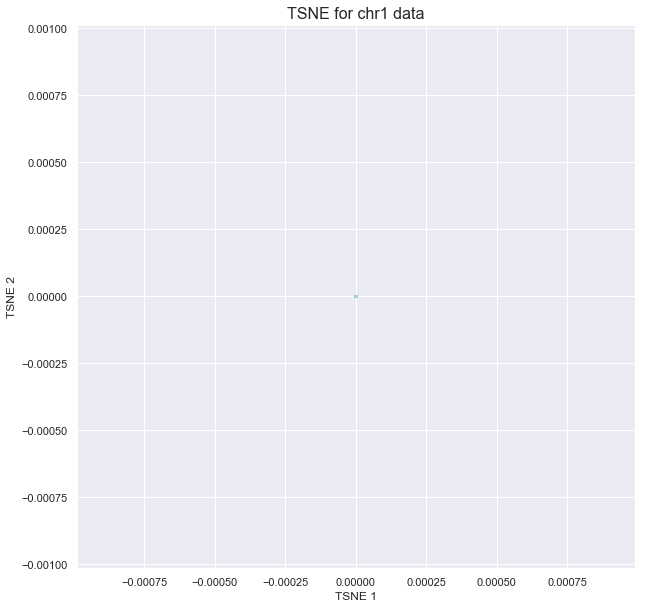

In [15]:
#Graphing represntation for normal T-SNE
#Currently is takes ~15 to 20mins
dim1 = X_embedded[:, 0]
dim2 = X_embedded[:, 1]
plt.figure(figsize=(10,10))
plt.scatter(dim1, dim2, cmap = 'Paired', c=df['label'], s =1)
plt.title("TSNE for chr1 data", fontsize=16)
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()

In [11]:
Z1 = fast_tsne(X_embedded)

Text(0, 0.5, 'FIt-SNE 2')

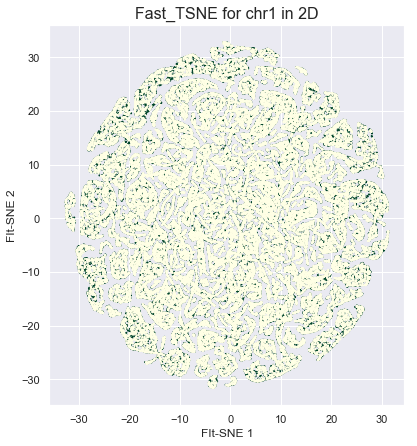

In [13]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.scatter(Z1[:,0], Z1[:,1],cmap='YlGn',c=df['label'], s=1)
plt.title('Fast_TSNE for chr1 in 2D', fontsize=16)
plt.xlabel('FIt-SNE 1')
plt.ylabel('FIt-SNE 2')

In [16]:
Z1 = fast_tsne(X_embedded, stop_early_exag_iter=500, initialization=pca_result)

Z2 = fast_tsne(X_embedded, learning_rate=10000, initialization=pca_result)


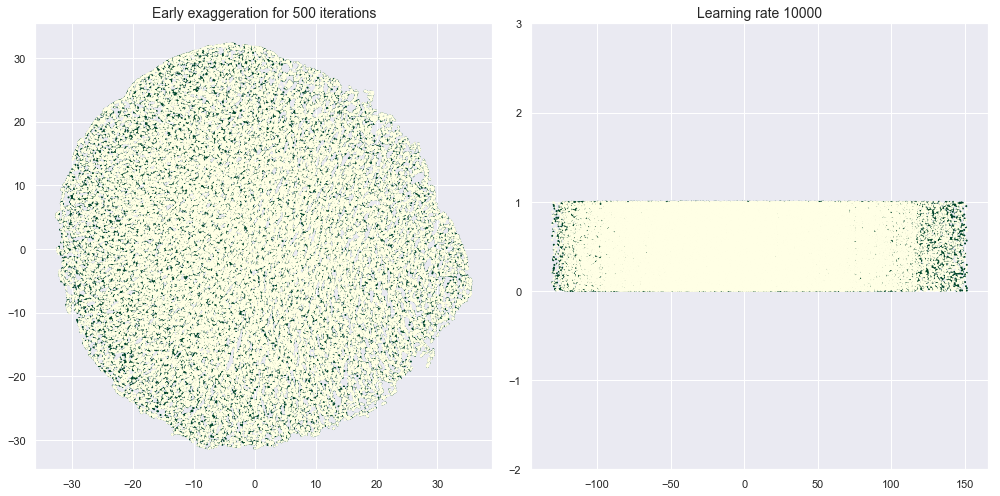

In [19]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.scatter(Z1[:,0], Z1[:,1], c=df['label'], cmap='YlGn', s=1)
plt.title('Early exaggeration for 500 iterations', fontsize=14)
plt.subplot(122)
plt.scatter(Z2[:,0], np.random.uniform(size=Z2.shape[0]), cmap='YlGn', c=df['label'], s=1)
plt.ylim([-2,3])
plt.title('Learning rate 10000', fontsize=14)
plt.tight_layout()

In [18]:
umapped = umap.UMAP().fit_transform(euc_ohe)

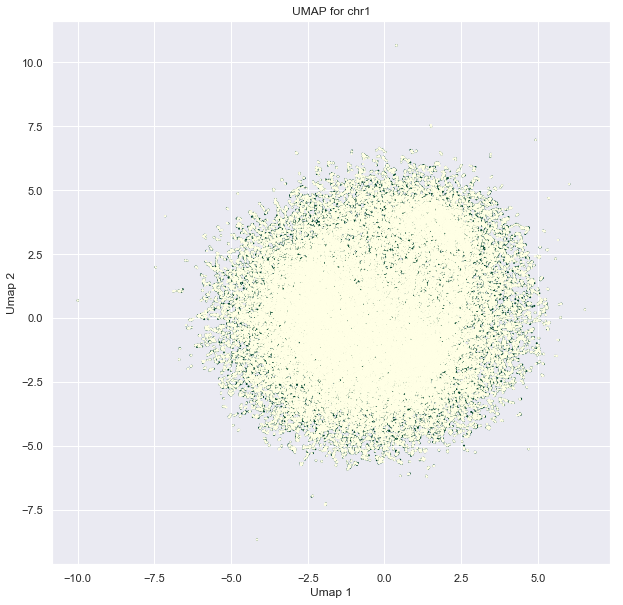

In [20]:
umap1 = umapped[:, 0]
umap2 = umapped[:, 1]
plt.figure(figsize=(10,10))
plt.scatter(umap1, umap2, cmap='YlGn', c=df['label'], s=1)
plt.title("UMAP for chr1")
plt.xlabel('Umap 1')
plt.ylabel('Umap 2')
plt.show()